In [100]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

2023-09-26 18:40:42.940414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## EDA

In [2]:
# Load the bank-full spreadsheet
df = pd.read_csv('/Users/jesse/Downloads/bank+marketing/bank/bank-full.csv', delimiter= ';')
# Display the first 5 rows to preview table
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# Display the dimension of the spreadsheet
df.shape

(45211, 17)

In [4]:
# Display column names
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [5]:
# Display the data types
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [6]:
# Display null values
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [7]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [8]:
# Subset the data to only have the numeric data
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Display the header
numeric_df.head()

,age,balance,day,duration,campaign,pdays,previous
0,58,2143,5,261,1,-1,0
1,44,29,5,151,1,-1,0
2,33,2,5,76,1,-1,0
3,47,1506,5,92,1,-1,0
4,33,1,5,198,1,-1,0


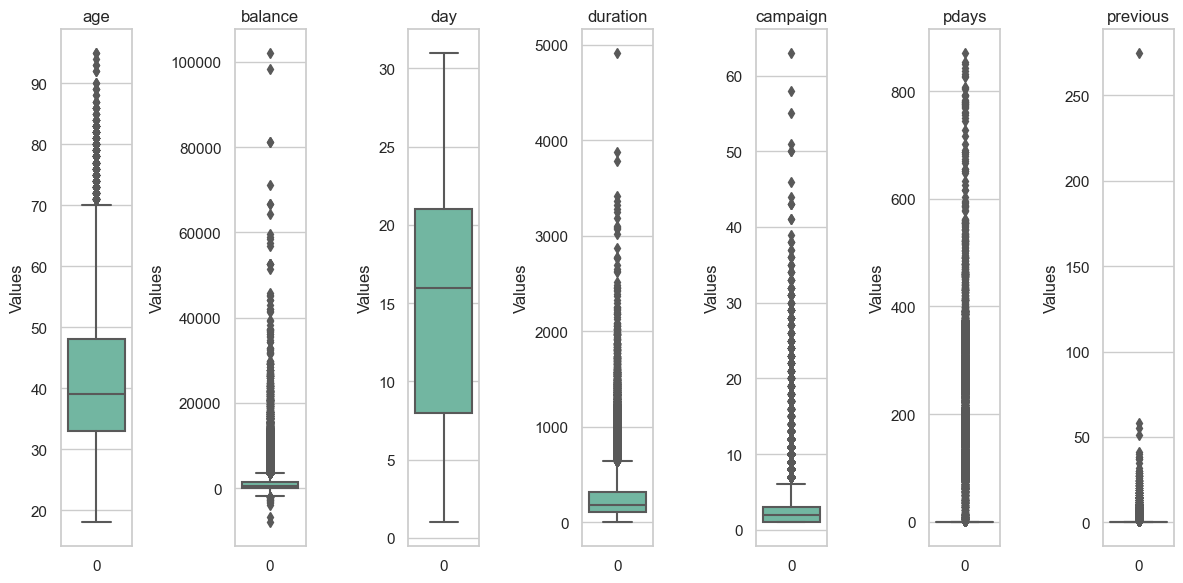

In [9]:
# Establish the style for the plots
sns.set(style="whitegrid")

# Create separate boxplots for each numeric column
plt.figure(figsize=(12, 6))

# Create a loop to generate independent subplots
for i, col in enumerate(numeric_df.columns, 1):
    plt.subplot(1, len(numeric_df.columns), i)
    sns.boxplot(data=numeric_df[col], orient="v", palette="Set2")
    plt.title(f'{col}')
    plt.ylabel('Values')
# Combine & display outputs
plt.tight_layout()
plt.show()

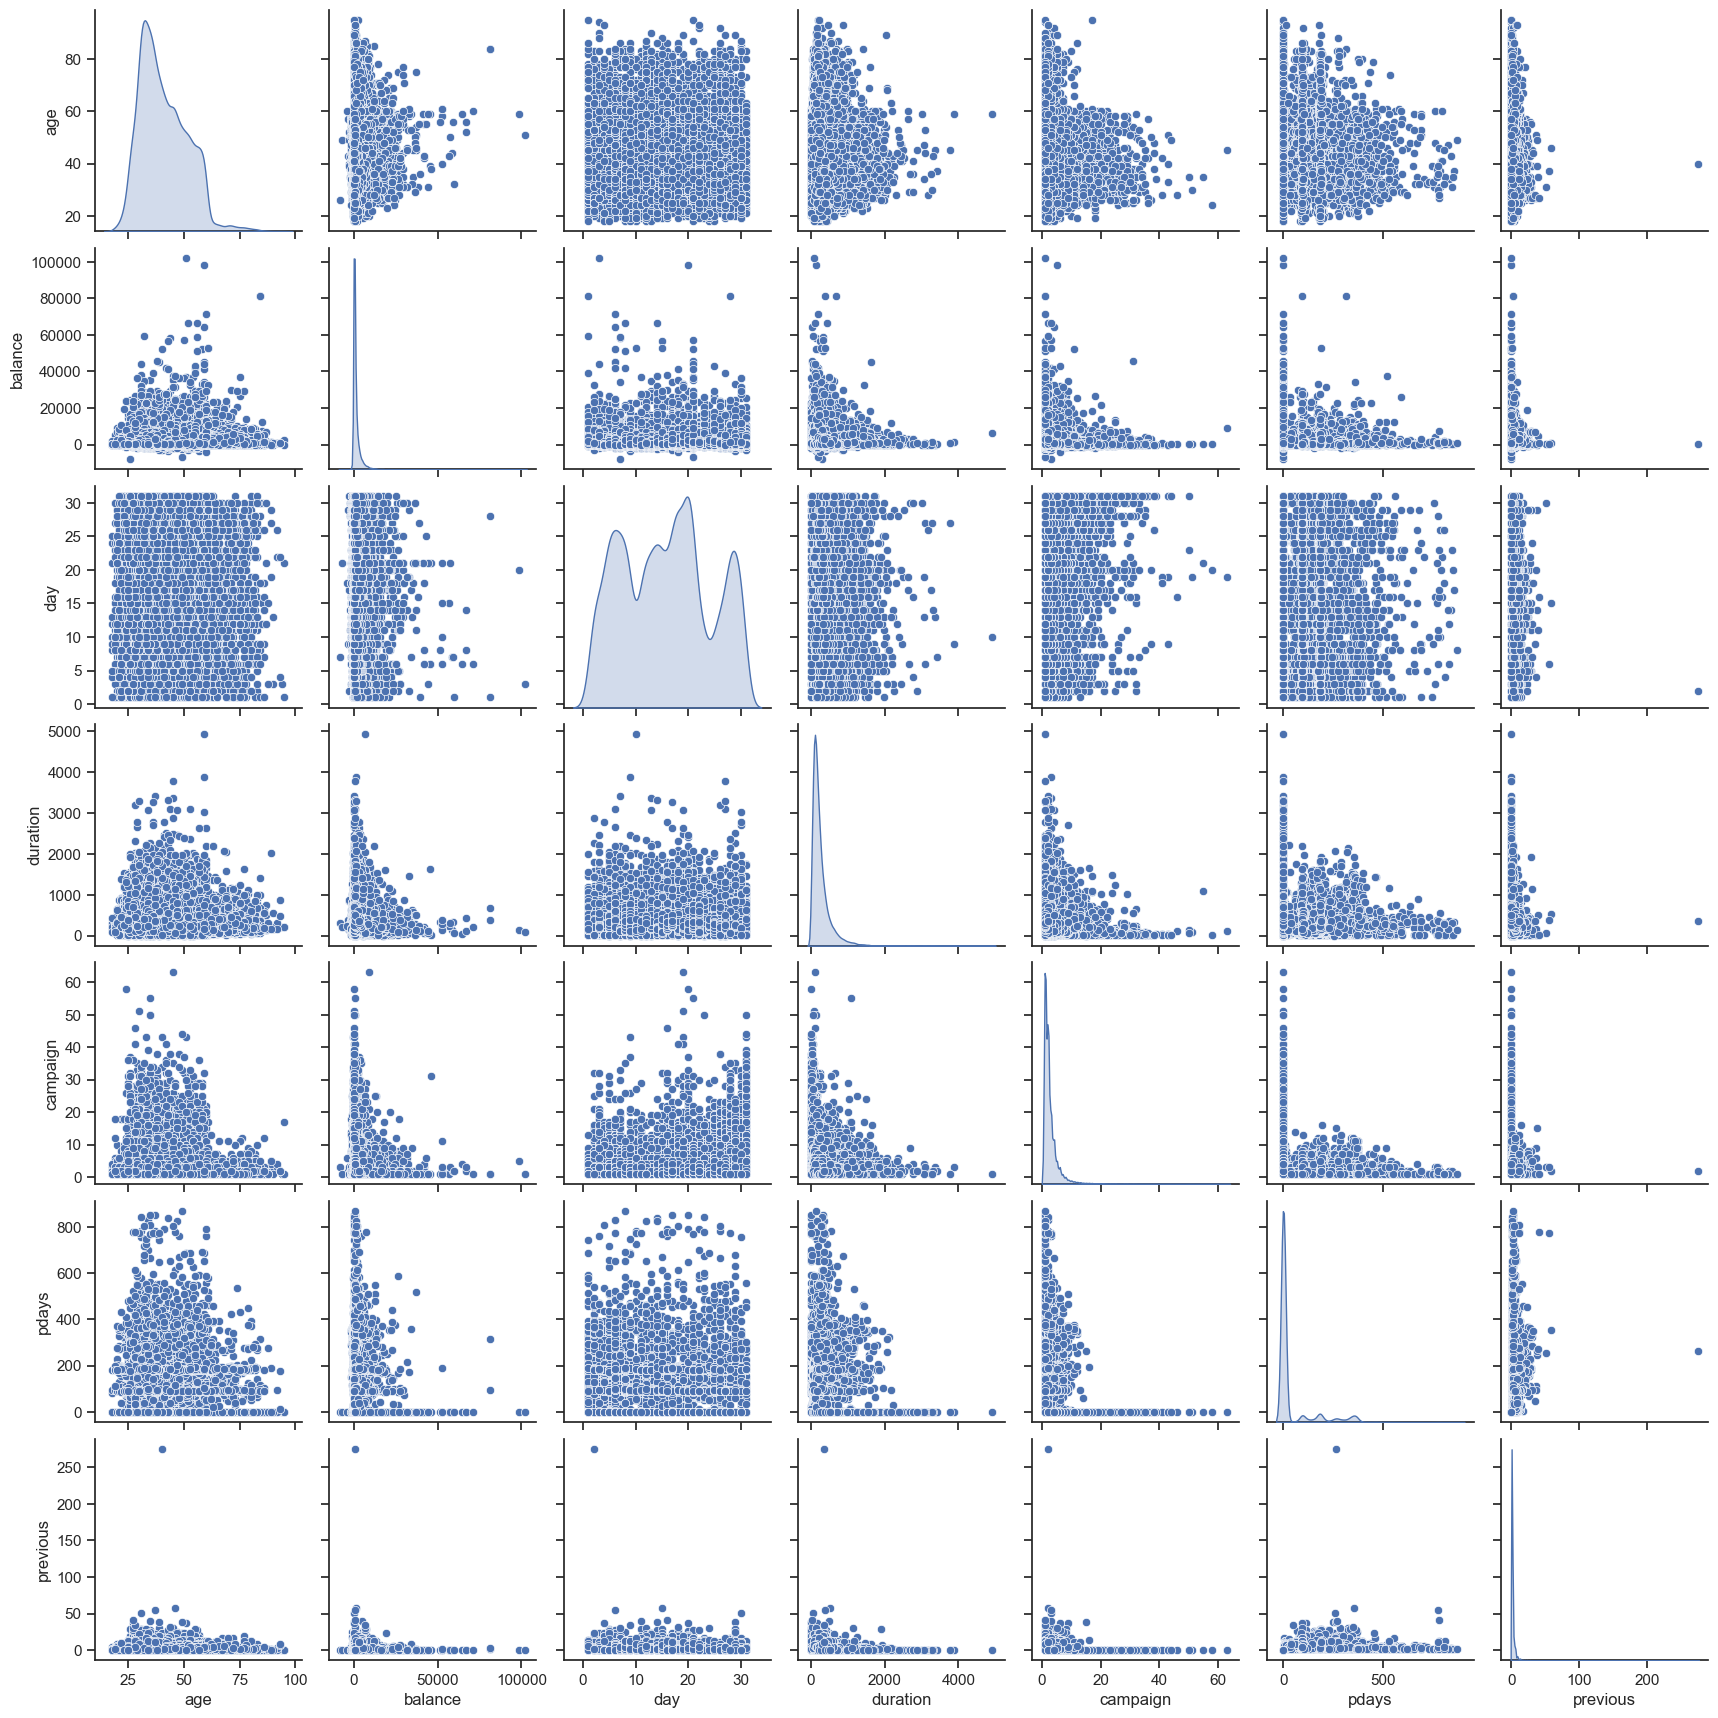

In [10]:
# Plot observations among all numeric attributes to compare distribution

# Establish the style for the plots
sns.set(style="ticks")

# Create pairplot
sns.pairplot(numeric_df, diag_kind='kde', markers='o')

# Display the plots
plt.show()

In [11]:
# Display unique outputs
df.nunique()

age            77
job            12
marital         3
education       4
default         2
balance      7168
housing         2
loan            2
contact         3
day            31
month          12
duration     1573
campaign       48
pdays         559
previous       41
poutcome        4
y               2
dtype: int64

In [12]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

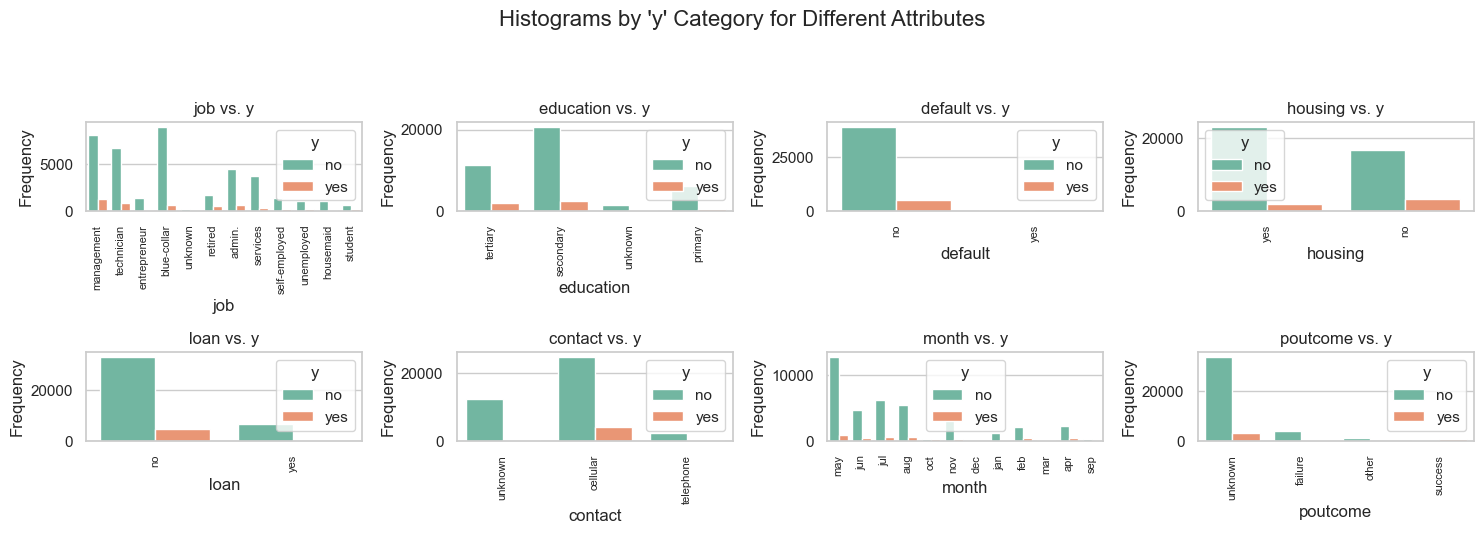

In [13]:
# Set the style for the plots (optional)
sns.set(style="whitegrid")

# List of columns to include in the grid
columns_to_compare = ['job', 'education', 'default', 'housing', 'loan', 'contact',
                      'month', 'poutcome']

# Create a grid of histograms comparing each column to 'y'
num_rows = 5
num_cols = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 12))
fig.suptitle("Histograms by 'y' Category for Different Attributes", fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Loop through the specified columns and create histograms for each
for i, col in enumerate(columns_to_compare):
    ax = axes[i]
    
    # Rotate x-axis labels by 45 degrees and set a smaller font size
    sns.countplot(data=df, x=col, hue='y', ax=ax, palette="Set2")
    ax.set_title(f'{col} vs. y')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=8)
    
# Remove any empty subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust the layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:
# Categorical columns to analyze
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'campaign', 'previous', 'poutcome']

# Varaible used to store the results
results = []

# Iterate through the categorical columns
for col in categorical_columns:
    unique_values = df[col].unique()
    for value in unique_values:
        sub_df = df[df[col] == value]
        total_count = sub_df.shape[0]  
        yes_count = sub_df[sub_df['y'] == 'yes'].shape[0]
        percentage = (yes_count / total_count) * 100 if total_count > 0 else 0.0
        results.append({'Column': col, 'Value': value, 'Percentage': percentage, 'Total Frequency': total_count})

# Save the results as a Data Frame
result_df = pd.DataFrame(results)

# Sort results in descending order
result_df = result_df.sort_values(by='Percentage', ascending=False)

# Display top 20 unique values
result_df.head(20)

,Column,Value,Percentage,Total Frequency
126,previous,55,100.000000,1
122,previous,58,100.000000,1
132,poutcome,success,64.725347,1511
37,month,mar,51.991614,477
106,previous,26,50.000000,2
34,month,dec,46.728972,214
39,month,sep,46.459413,579
32,month,oct,43.766938,738
97,previous,10,38.805970,67
121,previous,30,33.333333,3


In [15]:
# Wanted to further look at the distribution among each attribute
month_df = result_df[result_df['Column'] == 'month']
# Display table
month_df

,Column,Value,Percentage,Total Frequency
37,month,mar,51.991614,477
34,month,dec,46.728972,214
39,month,sep,46.459413,579
32,month,oct,43.766938,738
38,month,apr,19.679400,2932
36,month,feb,16.647792,2649
31,month,aug,11.013286,6247
29,month,jun,10.222805,5341
33,month,nov,10.151134,3970
35,month,jan,10.121169,1403


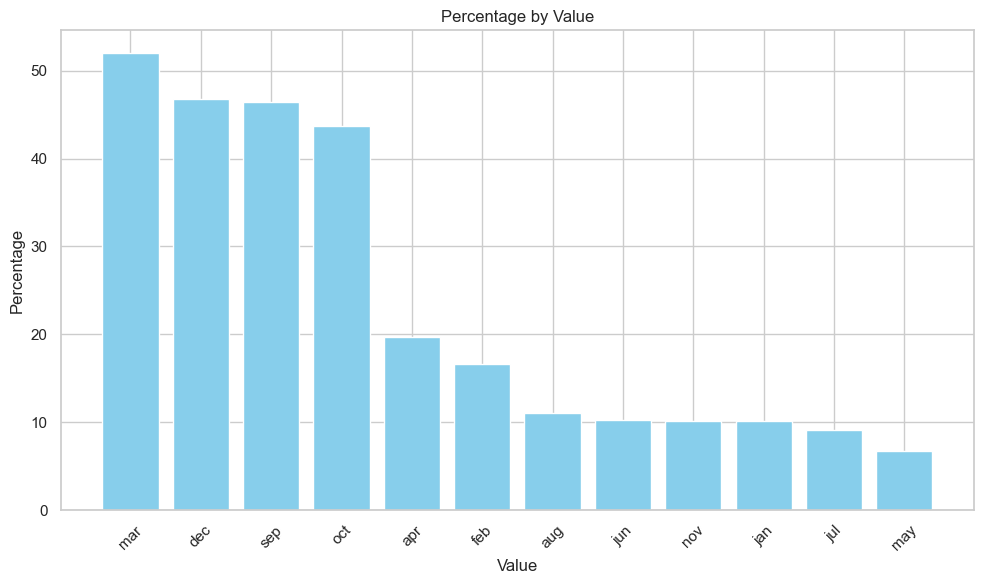

In [16]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(month_df['Value'], month_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [17]:
# Wanted to further look at the distribution among each attribute
marital_df = result_df[result_df['Column'] == 'marital']
# Display table
marital_df

,Column,Value,Percentage,Total Frequency
13,marital,single,14.949179,12790
14,marital,divorced,11.945458,5207
12,marital,married,10.123466,27214


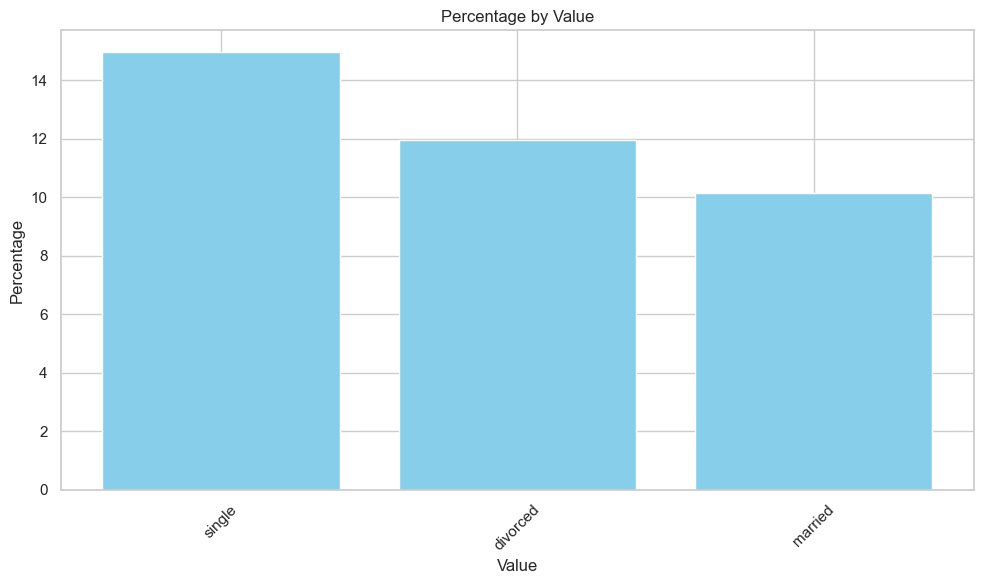

In [18]:
# Create bar plot for marital status
plt.figure(figsize=(10, 6))
plt.bar(marital_df['Value'], marital_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [19]:
# Wanted to further look at the distribution among each attribute
job_df = result_df[result_df['Column'] == 'job']
# Display table
job_df

,Column,Value,Percentage,Total Frequency
11,job,student,28.678038,938
5,job,retired,22.791519,2264
9,job,unemployed,15.502686,1303
0,job,management,13.755551,9458
6,job,admin.,12.202669,5171
8,job,self-employed,11.842939,1579
4,job,unknown,11.805556,288
1,job,technician,11.056996,7597
7,job,services,8.883004,4154
10,job,housemaid,8.790323,1240


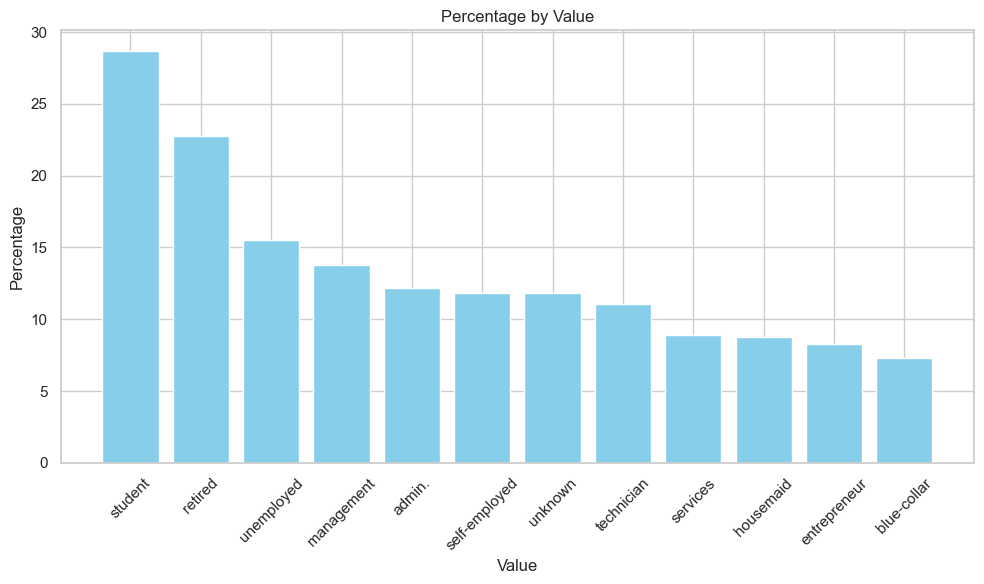

In [20]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(job_df['Value'], job_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [21]:
# Wanted to further look at the distribution among each attribute
education_df = result_df[result_df['Column'] == 'education']
# Display table
education_df

,Column,Value,Percentage,Total Frequency
15,education,tertiary,15.006390,13301
17,education,unknown,13.570275,1857
16,education,secondary,10.559435,23202
18,education,primary,8.626478,6851


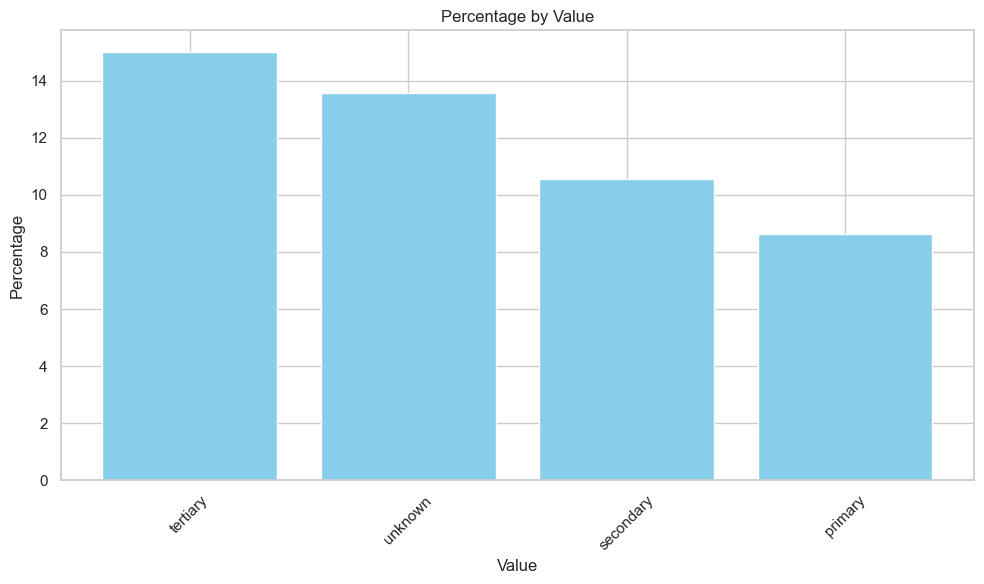

In [22]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(education_df['Value'], education_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [23]:
# Wanted to further look at the distribution among each attribute
default_df = result_df[result_df['Column'] == 'default']
# Display table
default_df

,Column,Value,Percentage,Total Frequency
19,default,no,11.796108,44396
20,default,yes,6.380368,815


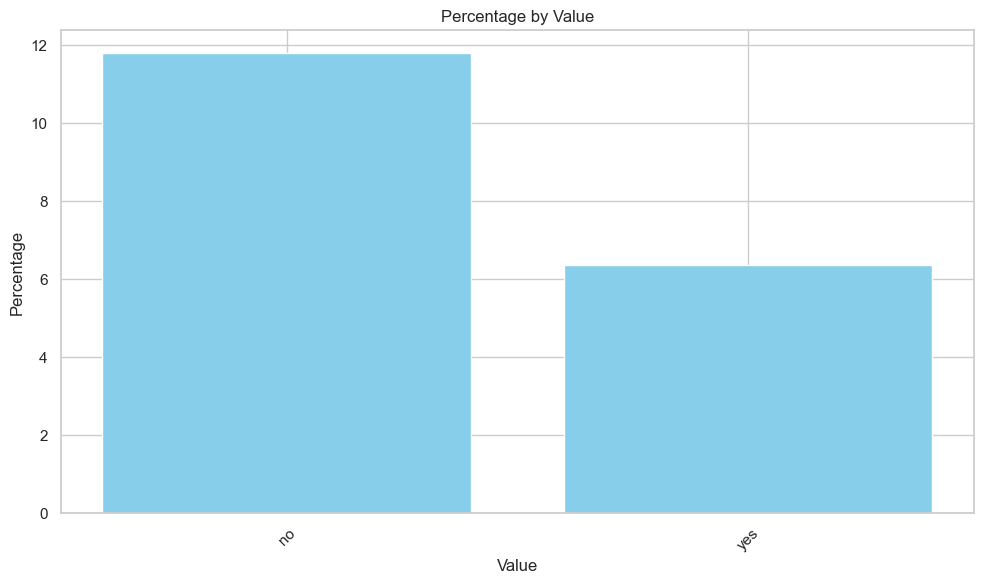

In [24]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(default_df['Value'], default_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [25]:
# Wanted to further look at the distribution among each attribute
housing_df = result_df[result_df['Column'] == 'housing']
# Display table
housing_df

,Column,Value,Percentage,Total Frequency
22,housing,no,16.702355,20081
21,housing,yes,7.699960,25130


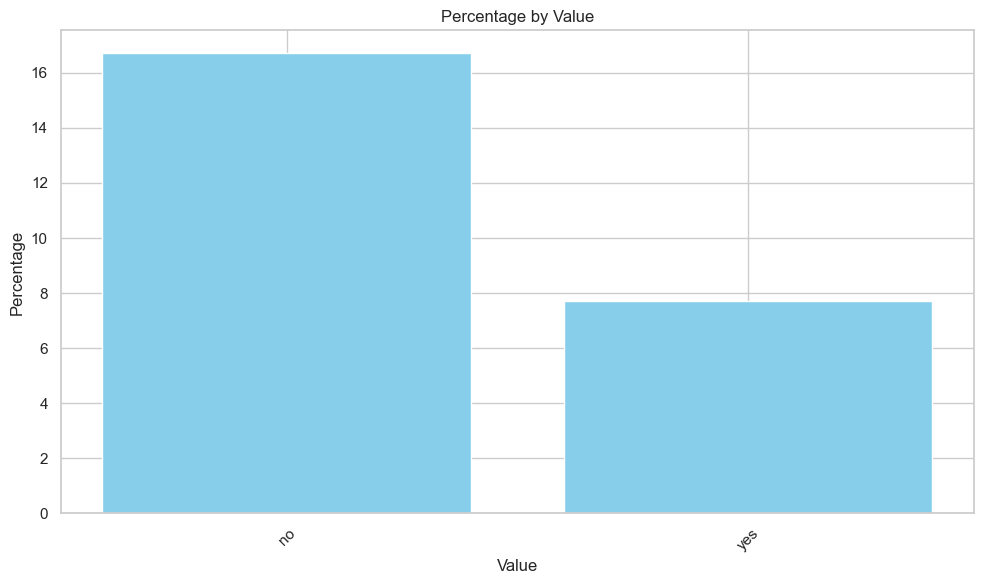

In [26]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(housing_df['Value'], housing_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [27]:
# Wanted to further look at the distribution among each attribute
loan_df = result_df[result_df['Column'] == 'loan']
# Display table
loan_df

,Column,Value,Percentage,Total Frequency
23,loan,no,12.655727,37967
24,loan,yes,6.681391,7244


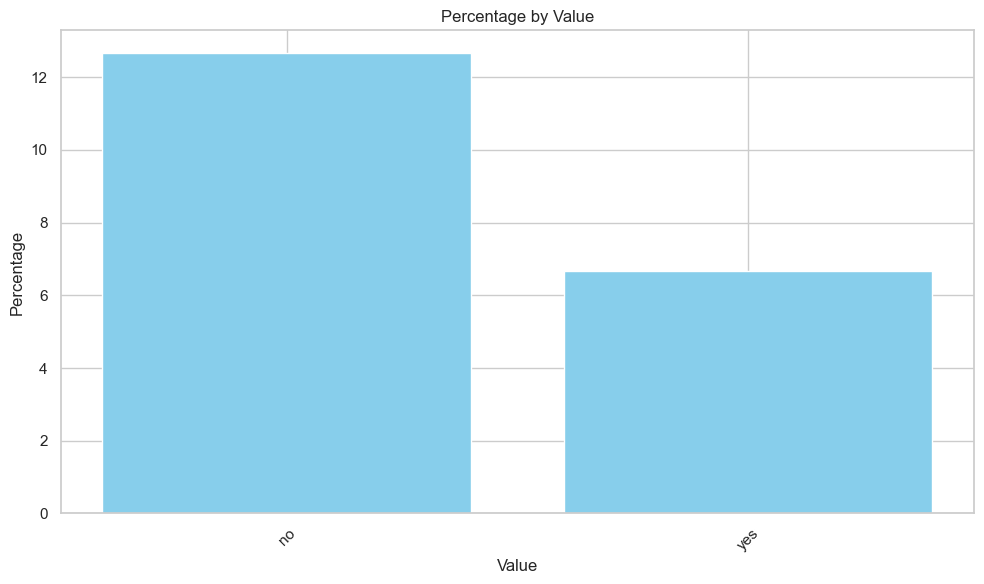

In [28]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(loan_df['Value'], loan_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [29]:
# Wanted to further look at the distribution among each attribute
contact_df = result_df[result_df['Column'] == 'contact']
# Display table
contact_df

,Column,Value,Percentage,Total Frequency
26,contact,cellular,14.918900,29285
27,contact,telephone,13.420509,2906
25,contact,unknown,4.070661,13020


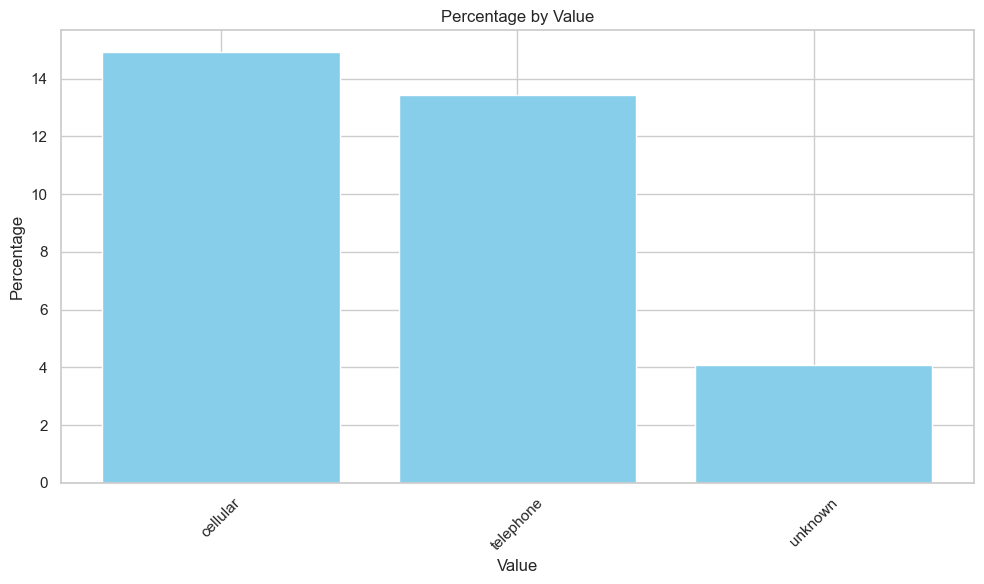

In [30]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(contact_df['Value'], contact_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [31]:
# Wanted to further look at the distribution among each attribute
campaign_df = result_df[result_df['Column'] == 'campaign']
# Display table
campaign_df

,Column,Value,Percentage,Total Frequency
40,campaign,1,14.597583,17544
41,campaign,2,11.203519,12505
42,campaign,3,11.193624,5521
57,campaign,32,11.111111,9
44,campaign,4,9.000568,3522
61,campaign,17,8.695652,69
50,campaign,11,7.960199,201
43,campaign,5,7.879819,1764
45,campaign,6,7.126259,1291
48,campaign,9,6.422018,327


In [32]:
# Determine the min. freq. to display w/in table using 5%
campaign_cutoff = round(len(campaign_df) * .05, 0)
# Display the minimum amount of observations that a value needs to be included
print('Minumum observations for campaign results: ', campaign_cutoff)
# Display table
campaign_cutoff_df = campaign_df[campaign_df['Total Frequency'] > campaign_cutoff] 
# Print updated table
campaign_cutoff_df

Minumum observations for campaign results:  2.0


,Column,Value,Percentage,Total Frequency
40,campaign,1,14.597583,17544
41,campaign,2,11.203519,12505
42,campaign,3,11.193624,5521
57,campaign,32,11.111111,9
44,campaign,4,9.000568,3522
61,campaign,17,8.695652,69
50,campaign,11,7.960199,201
43,campaign,5,7.879819,1764
45,campaign,6,7.126259,1291
48,campaign,9,6.422018,327


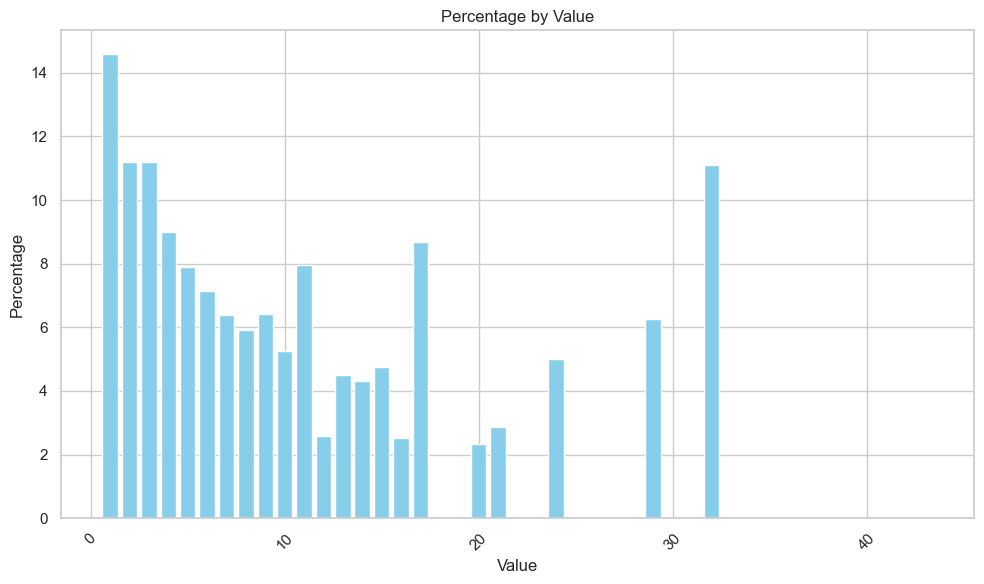

In [33]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(campaign_cutoff_df['Value'], campaign_cutoff_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [34]:
# Wanted to further look at the distribution among each attribute
previous_df = result_df[result_df['Column'] == 'previous']
# Display table
previous_df

,Column,Value,Percentage,Total Frequency
126,previous,55,100.000000,1
122,previous,58,100.000000,1
106,previous,26,50.000000,2
97,previous,10,38.805970,67
121,previous,30,33.333333,3
103,previous,8,30.232558,129
95,previous,6,29.963899,277
96,previous,5,26.361656,459
99,previous,7,26.341463,205
104,previous,14,26.315789,19


In [35]:
# Establish min. freq. based on cutoff value of 5%
percentage_cutoff = round(len(previous_df) * .05, 0)
# Display the min. amount of freq.
print('Percent cutoff: ', percentage_cutoff)
# Create a subset accounting for cutoff
previous_cutoff_df = previous_df[previous_df['Total Frequency'] > percentage_cutoff]
# Display results
previous_cutoff_df

Percent cutoff:  2.0


,Column,Value,Percentage,Total Frequency
97,previous,10,38.805970,67
121,previous,30,33.333333,3
103,previous,8,30.232558,129
95,previous,6,29.963899,277
96,previous,5,26.361656,459
99,previous,7,26.341463,205
104,previous,14,26.315789,19
101,previous,9,26.086957,92
89,previous,3,25.744308,1142
102,previous,21,25.000000,4


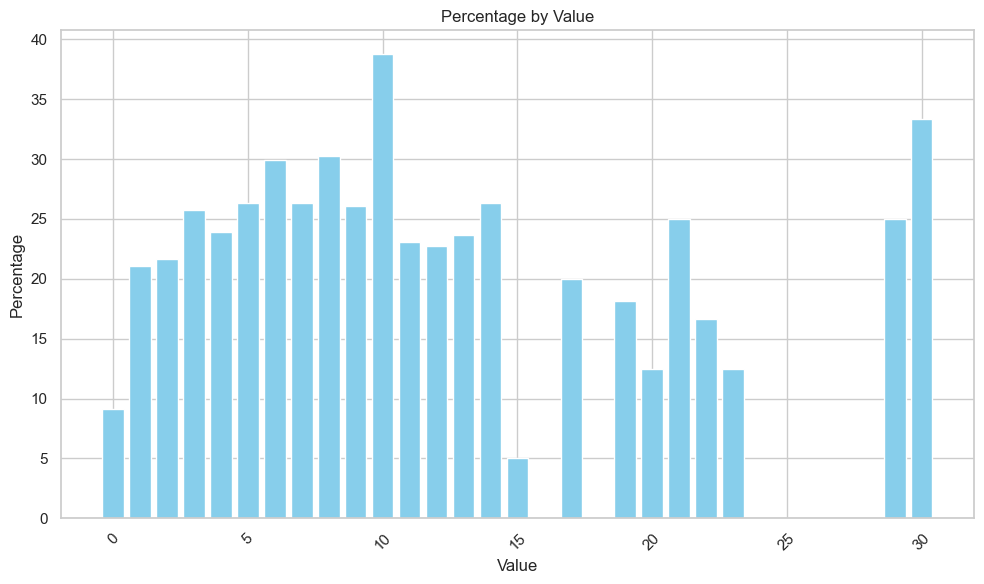

In [36]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(previous_cutoff_df['Value'], previous_cutoff_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [37]:
# Wanted to further look at the distribution among each attribute
poutcome_df = result_df[result_df['Column'] == 'poutcome']
# Display table
poutcome_df

,Column,Value,Percentage,Total Frequency
132,poutcome,success,64.725347,1511
131,poutcome,other,16.684783,1840
130,poutcome,failure,12.609671,4901
129,poutcome,unknown,9.161503,36959


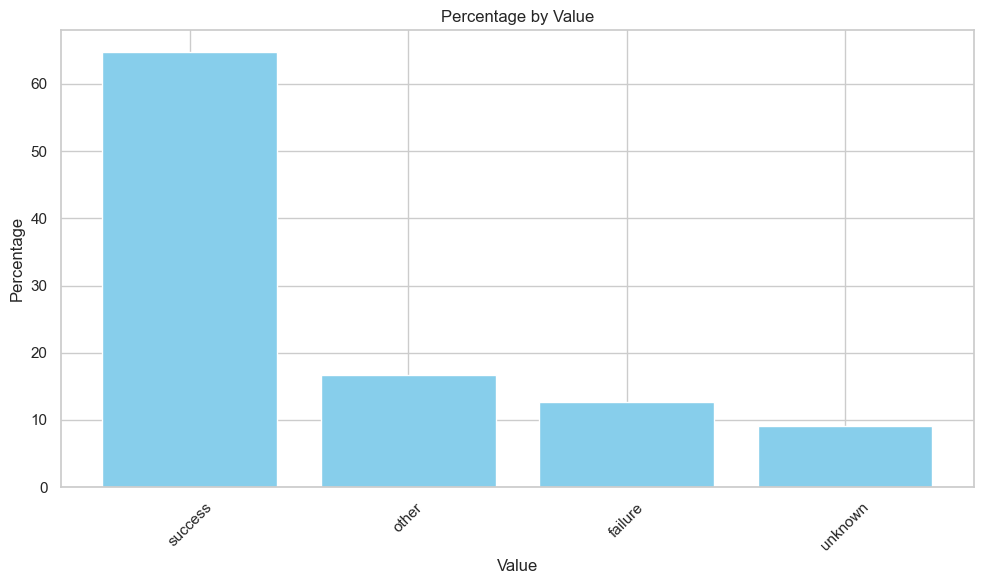

In [38]:
# Create bar plot for month attributee
plt.figure(figsize=(10, 6))
plt.bar(poutcome_df['Value'], poutcome_df['Percentage'], color='skyblue')
plt.xlabel('Value')
plt.ylabel('Percentage')
plt.title('Percentage by Value')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

## Data Pre-Processing

In [40]:
# Replace 'unknown' values with NaN
df.replace('unknown', np.nan, inplace=True)

# Create a copy of the DataFrame with categorical attributes as factors
df_factors = df.copy()

# Replace 'unknown' values with NaN
df_factors.replace('unknown', np.nan, inplace=True)

# Convert categorical columns to factors
categorical_columns = df_factors.select_dtypes(include=['object']).columns
for col in categorical_columns:
    df_factors[col] = pd.factorize(df_factors[col])[0]

for column in df_factors.columns:
    unique_values = df_factors[column].unique()
    print(f"Column: {column}\nUnique Values: {unique_values}\n")

Column: age
Unique Values: [58 44 33 47 35 28 42 43 41 29 53 57 51 45 60 56 32 25 40 39 52 46 36 49
 59 37 50 54 55 48 24 38 31 30 27 34 23 26 61 22 21 20 66 62 83 75 67 70
 65 68 64 69 72 71 19 76 85 63 90 82 73 74 78 80 94 79 77 86 95 81 18 89
 84 87 92 93 88]

Column: job
Unique Values: [ 0  1  2  3 -1  4  5  6  7  8  9 10]

Column: marital
Unique Values: [0 1 2]

Column: education
Unique Values: [ 0  1 -1  2]

Column: default
Unique Values: [0 1]

Column: balance
Unique Values: [ 2143    29     2 ...  8205 14204 16353]

Column: housing
Unique Values: [0 1]

Column: loan
Unique Values: [0 1]

Column: contact
Unique Values: [-1  0  1]

Column: day
Unique Values: [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24 25  1 10 22 31]

Column: month
Unique Values: [ 0  1  2  3  4  5  6  7  8  9 10 11]

Column: duration
Unique Values: [ 261  151   76 ... 1298 1246 1556]

Column: campaign
Unique Values: [ 1  2  3  5  4  6  7  8  9 10 11 12 13 19 14 24 16 32 18 22 

In [41]:
# The factorize fx replaced all NaN values w/ a -1
# Replace all -1 values with NaN, excluding the 'pdays' column which uses -1 as a value
columns_to_exclude = ['pdays'] 
for column in df_factors.columns:
    if column not in columns_to_exclude:
        df_factors[column].replace(-1, np.nan, inplace=True)

In [42]:
# Compare both dataset to ensure that they have the right amount of null values
print('Original Dataset Null Values: ')
print(df.isna().sum())
print('Factored Dataset Null Values: ')
print(df_factors.isna().sum())

Original Dataset Null Values: 
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Factored Dataset Null Values: 
age              0
job            288
marital          0
education     1857
default          0
balance         50
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64


In [43]:
# Initialize the K-NN imputer
knn_imputer = KNNImputer(n_neighbors=5)  

# Apply K-NN imputation to fill missing values
df_factors_imputed = knn_imputer.fit_transform(df_factors)

# Convert the imputed array back to a DataFrame with column names
df_factors_imputed = pd.DataFrame(df_factors_imputed, columns=df_factors.columns)

# Check if there are any remaining NaN values
print(df_factors_imputed.isna().sum())

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [44]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on your data
df_scaled = scaler.fit_transform(df_factors_imputed)

# Convert the scaled array back to a DataFrame with original column names
df_scaled = pd.DataFrame(df_scaled, columns=df_factors_imputed.columns)

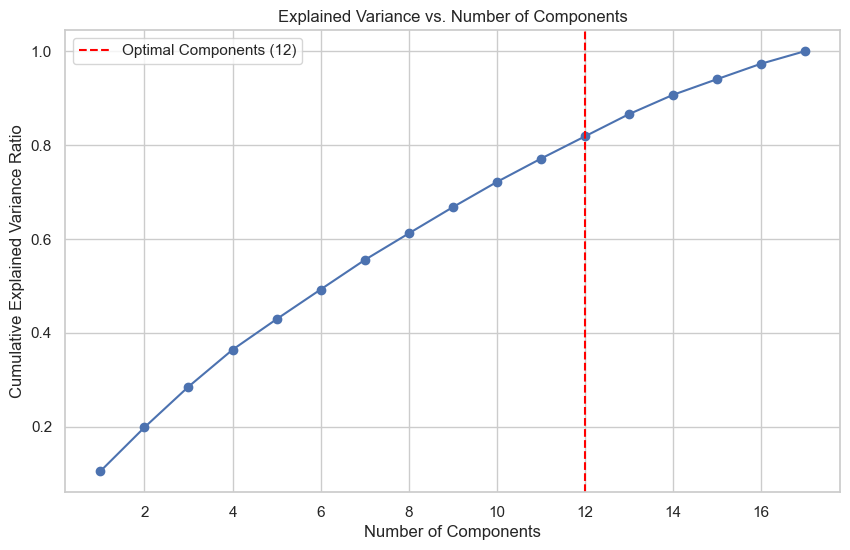

Optimal number of components: 12


In [47]:
# Initialize PCA with a large number of components
pca = PCA()

# Fit PCA on your scaled data
pca.fit(df_scaled)

# Plot the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.title("Explained Variance vs. Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.grid(True)

# Determine the optimal number of components based on the plot
# You can choose a threshold (e.g., 0.95) and find the corresponding number of components
threshold = 0.8
optimal_num_components = np.argmax(cumulative_variance_ratio >= threshold) + 1

plt.axvline(x=optimal_num_components, color='red', linestyle='--', label=f'Optimal Components ({optimal_num_components})')
plt.legend()

plt.show()

print(f"Optimal number of components: {optimal_num_components}")

In [70]:
# I deemed 12 as the ideal number of components capturing >80% of cumulative explained variance
pca = PCA(n_components=12)
X_pca = pca.fit_transform(df_scaled)

# Convert to a DataFrame from X_pca w/ original column names
pca_column_names = [f'PC{i}' for i in range(1, 13)]
X_pca_df = pd.DataFrame(X_pca, columns=pca_column_names)

# Create a dictionary to map PCA column names to original
pca_to_original_mapping = {pca_column_names[i]: df_scaled.columns[i] for i in range(12)}  # Start from 0

# Use the mapping to match PCA component names to original columns
matching_columns = [pca_to_original_mapping[pca_col] for pca_col in X_pca_df.columns]

# Rename column names
X_pca_df.rename(columns=pca_to_original_mapping, inplace=True)

# Add 'y' column from df_factors_imputed to X_pca_df
X_pca_df['y'] = df_factors_imputed['y']

# Display table
X_pca_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,y
0,-0.687135,-0.597637,-0.309854,0.464055,-1.766122,0.714227,-1.694821,1.078205,1.357580,0.396462,0.156698,0.457242,0.0
1,-0.532368,0.667937,-0.526189,-0.670603,-1.364265,-0.222982,-0.595480,0.340474,1.102143,0.130100,0.119902,0.665130,0.0
2,-0.956093,1.402165,-0.195139,-0.840161,-0.303867,0.068419,-1.932555,0.773284,0.000387,-1.283574,0.501690,-0.835905,0.0
3,-0.735599,0.434300,0.145310,-0.463086,-1.660499,0.104556,-0.883838,0.593800,0.323999,0.672682,0.381716,0.148452,0.0
4,-0.513638,-0.067233,-0.590106,-0.682893,-0.950669,-1.159882,-0.187621,0.224073,0.690191,0.195406,0.510607,0.045345,0.0


In [67]:
# Display the dimensions of the dataset
X_pca_df.shape

(45211, 12)

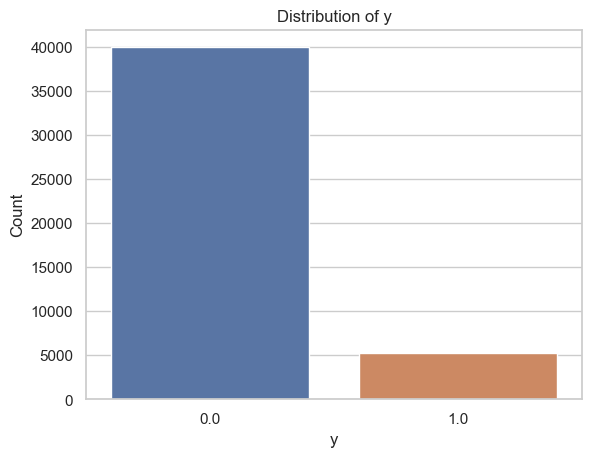

In [91]:
# Display distribution of predictor variable
sns.countplot(data=X_pca_df, x='y')
plt.xlabel('y')
plt.ylabel('Count')
plt.title('Distribution of y')
plt.show()

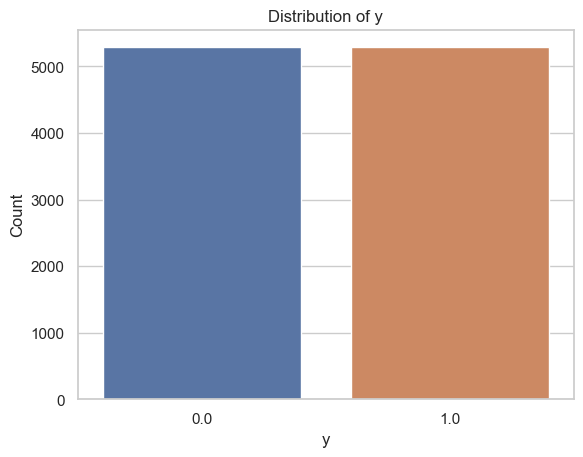

In [93]:

# Isolate outcome freq. for random undersampling
positive_class = X_pca_df[X_pca_df['y'] == 1]
negative_class = X_pca_df[X_pca_df['y'] == 0]

# Randomly sample the same number of negative class as positive class
num_samples = len(positive_class)
balanced_subset = negative_class.sample(n=num_samples, random_state=1)

# Combine the balanced subsets
balanced_data = pd.concat([positive_class, balanced_subset])

# Shuffle the rows to randomize the order
balanced_data = balanced_data.sample(frac=1, random_state=1).reset_index(drop=True)

# Display distribution
sns.countplot(data=balanced_data, x='y')
plt.xlabel('y')
plt.ylabel('Count')
plt.title('Distribution of y')
plt.show()

In [94]:
# Split the data into train & temporary sets (70% train + 30% temp)
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(balanced_data.drop(columns=['y']), balanced_data['y'], test_size=0.3, random_state=1)

# Split the temporary data into validation and test sets (50% validation + 50% test)
X_validate, X_test, y_validate, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

# Display the dimensions of the subsets
print("Train set shape:", X_train_temp.shape)
print("Validation set shape:", X_validate.shape)
print("Test set shape:", X_test.shape)

Train set shape: (7404, 12)
Validation set shape: (1587, 12)
Test set shape: (1587, 12)


## Model Development

### Neural Network

2023-09-26 18:41:23.816902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
232/232 [==============================] - 2s 4ms/step - loss: 0.3113 - accuracy: 0.9079
Epoch 2/10
232/232 [==============================] - 0s 2ms/step - loss: 0.0752 - accuracy: 0.9873
Epoch 3/10
232/232 [==============================] - 1s 2ms/step - loss: 0.0466 - accuracy: 0.9901
Epoch 4/10
232/232 [==============================] - 0s 2ms/step - loss: 0.0366 - accuracy: 0.9912
Epoch 5/10
232/232 [==============================] - 1s 3ms/step - loss: 0.0315 - accuracy: 0.9919
Epoch 6/10
232/232 [==============================] - 1s 4ms/step - loss: 0.0283 - accuracy: 0.9931
Epoch 7/10
232/232 [==============================] - 0s 2ms/step - loss: 0.0261 - accuracy: 0.9931
Epoch 8/10
232/232 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9935
Epoch 9/10
232/232 [==============================] - 0s 2ms/step - loss: 0.0231 - accuracy: 0.9943
Epoch 10/10
50/50 [==============================] - 0s 1ms/step
Validation Accuracy: 0.989287964713

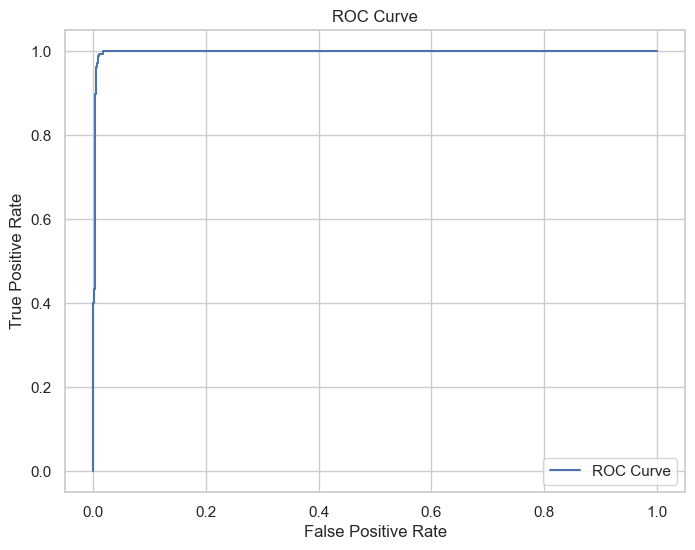

In [101]:
# Build simple neural network model
model = keras.Sequential([
    keras.layers.Input(shape=(12,)),  
    keras.layers.Dense(64, activation='relu'), 
    keras.layers.Dense(1, activation='sigmoid') 
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_temp, y_train_temp, epochs=10, batch_size=32)

# Make predictions on the validation set
y_pred = model.predict(X_validate)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_validate, y_pred_binary)
print("Validation Accuracy:", accuracy)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_validate, y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)

# Calculate classification report
class_report = classification_report(y_validate, y_pred_binary)
print("Classification Report:\n", class_report)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_validate, y_pred)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_validate, y_pred)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

50/50 [==============================] - 0s 1ms/step
Test Accuracy: 0.9905482041587902
Confusion Matrix:
 [[745  12]
 [  3 827]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       757
         1.0       0.99      1.00      0.99       830

    accuracy                           0.99      1587
   macro avg       0.99      0.99      0.99      1587
weighted avg       0.99      0.99      0.99      1587

ROC AUC Score: 0.9981887921567378


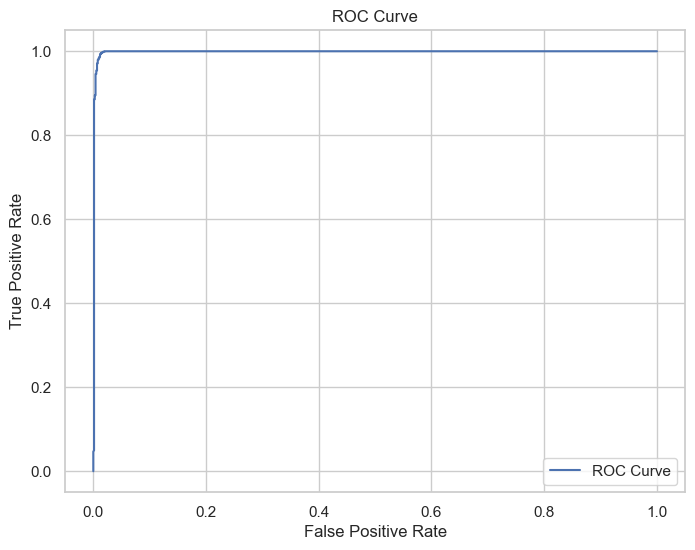

In [102]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred_binary)
print("Test Accuracy:", accuracy)

# Display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)

# Calculate classification report
class_report = classification_report(y_test, y_pred_binary)
print("Classification Report:\n", class_report)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Gradient Boosting

Validation Accuracy: 0.9873976055450535
Confusion Matrix:
 [[782  15]
 [  5 785]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       797
         1.0       0.98      0.99      0.99       790

    accuracy                           0.99      1587
   macro avg       0.99      0.99      0.99      1587
weighted avg       0.99      0.99      0.99      1587

ROC AUC Score: 0.9980051776440131


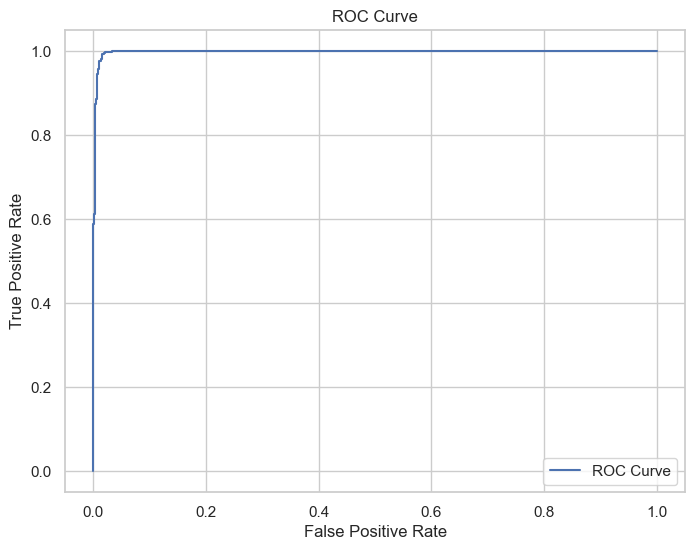

In [95]:
# Build XGBoost classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=3, random_state=1)

# Train the model
xgb_model.fit(X_train_temp, y_train_temp)

# Make predictions on the validation set
y_pred = xgb_model.predict(X_validate)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_validate, y_pred)
print("Validation Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_validate, y_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_validate, y_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = xgb_model.predict_proba(X_validate)[:, 1]
roc_auc = roc_auc_score(y_validate, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_validate, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

Test Accuracy: 0.9880277252678009
Confusion Matrix:
 [[746  11]
 [  8 822]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       757
         1.0       0.99      0.99      0.99       830

    accuracy                           0.99      1587
   macro avg       0.99      0.99      0.99      1587
weighted avg       0.99      0.99      0.99      1587

ROC AUC Score: 0.9981020515350703


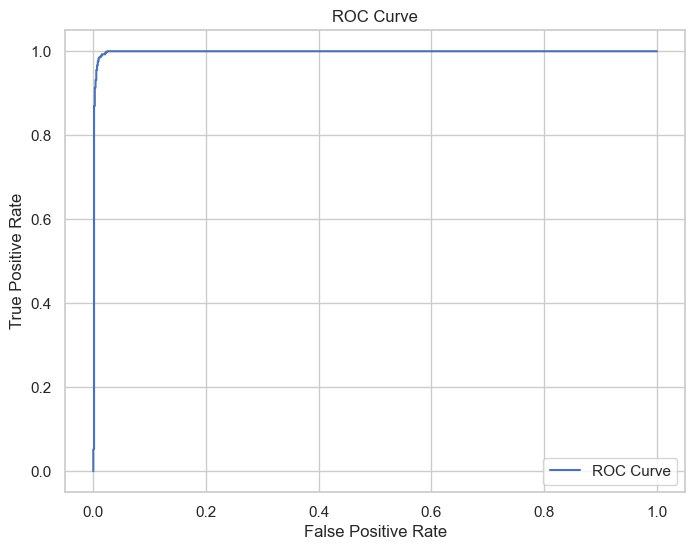

In [96]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Display confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion)

# Conduct classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Calculate ROC AUC
y_prob = xgb_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Support Vector Machine

Validation Accuracy: 0.9892879647132955
Confusion Matrix:
 [[784  13]
 [  4 786]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       797
         1.0       0.98      0.99      0.99       790

    accuracy                           0.99      1587
   macro avg       0.99      0.99      0.99      1587
weighted avg       0.99      0.99      0.99      1587

ROC AUC Score: 0.9974461191493417


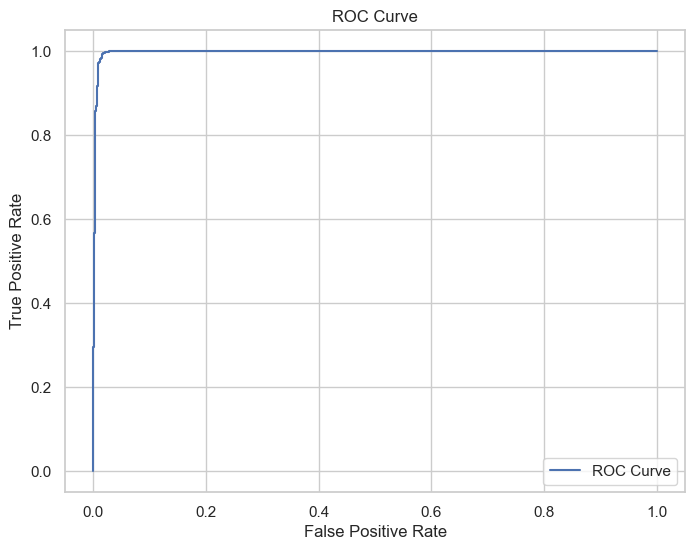

In [97]:
# Set parameters for SVM classifier
svm_model = SVC(kernel='linear', C=1, probability=True, random_state=1)

# Train the model
svm_model.fit(X_train_temp, y_train_temp)

# Make predictions on the validation set
y_pred = svm_model.predict(X_validate)

# Calculate accuracy on the validation set
accuracy = accuracy_score(y_validate, y_pred)
print("Validation Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_validate, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Conduct classification report
class_report = classification_report(y_validate, y_pred)
print("Classification Report:\n", class_report)

# Calculate ROC AUC
y_scores = svm_model.decision_function(X_validate)
roc_auc = roc_auc_score(y_validate, y_scores)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_validate, y_scores)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

Test Accuracy: 0.9873976055450535
Confusion Matrix:
 [[741  16]
 [  4 826]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       757
         1.0       0.98      1.00      0.99       830

    accuracy                           0.99      1587
   macro avg       0.99      0.99      0.99      1587
weighted avg       0.99      0.99      0.99      1587

ROC AUC Score: 0.9966386019639987


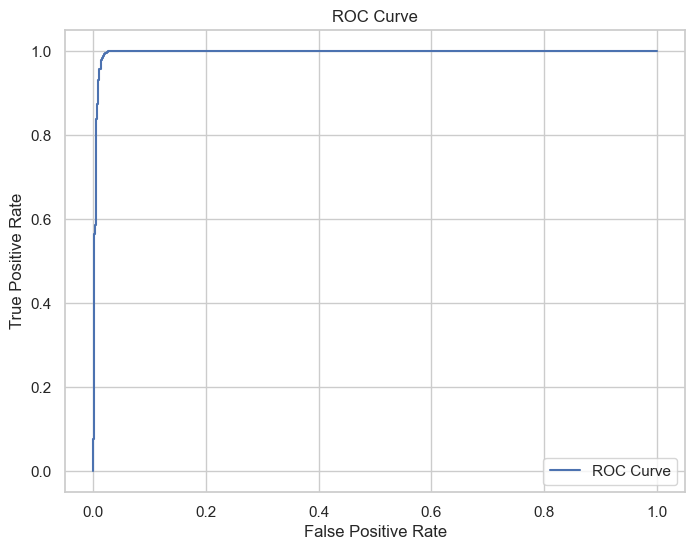

In [98]:
# Make predictions using the test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

# Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Conduct classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Calculate ROC AUC
y_scores = svm_model.decision_function(X_test)
roc_auc = roc_auc_score(y_test, y_scores)
print("ROC AUC Score:", roc_auc)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)

# Display ROC curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()